In [1]:
from urllib.request import urlopen, urlretrieve
import tqdm

In [2]:
# 歷史資料網址
data_baseurl="http://tisvcloud.freeway.gov.tw/history/TDCS/M06A/"
# 壓縮檔的檔名格式
filename_format="M06A_{year:04d}{month:02d}{day:02d}.tar.gz".format
# csv 檔的路徑格式
csv_format = "M06A/{year:04d}{month:02d}{day:02d}/{hour:02d}/TDCS_M06A_{year:04d}{month:02d}{day:02d}_{hour:02d}0000.csv".format
# 下載檔案的程式
# 如果有 ipywidgets, 可以將 tqdm.tqdm 換成 tqdm.tqdm_notebook 比較 notebook 一點的界面

# 將 req 下載到檔案
def download_req(req, filename):
    # 取得檔案長度
    total = int(req.getheader("Content-Length"))
    # tqdm 的設定
    tqdm_conf = dict(total=total, desc=filename, unit='B', unit_scale=True)
    # 開啟 tqdm 進度條及寫入檔案
    with tqdm.tqdm(**tqdm_conf) as pbar:
        with open(filename,'wb') as f:
            # 從 req 每次讀入 8192 byte 的資料
            for data in iter(lambda: req.read(8192), b""):  
                # 寫入檔案，並且更新進度條
                pbar.update(f.write(data))
                
def download_M06A(year, month, day):
    # 依照年月日來設定檔名
    filename = filename_format(year=year, month=month, day=day)
    # 用 urlopen 開啟連結
    with urlopen(data_baseurl + filename) as req:
        download_req(req, filename)
download_M06A(2016,11,11)

M06A_20161111.tar.gz: 100%|█████████████████████████████████████████████████████████| 154M/154M [01:01<00:00, 2.49MB/s]


In [3]:
import tarfile
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from urllib.request import urlopen
from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')
data_config ={"year":2016, "month":11, "day":11}
tar = tarfile.open(filename_format(**data_config), 'r')

In [4]:
# 設定欄位名稱
M06A_fields = ['VehicleType',
               'DetectionTime_O','GantryID_O',
               'DetectionTime_D','GantryID_D ',
               'TripLength', 'TripEnd', 'TripInformation']
# 打開裡面 10 點鐘的資料
csv = tar.extractfile(csv_format(hour=12, **data_config))
# 讀進資料
data = pandas.read_csv(csv, names=M06A_fields)
# 檢查異常的資料
print("異常資料數:", data[data.TripEnd == 'N'].shape[0])
# 去除異常資料
data = data[data.TripEnd == 'Y']
# 只保留 TripInformation 和 VehicleType
data = data[['VehicleType', "TripInformation"]]
# 看前五筆
data.head(5)

異常資料數: 0


,VehicleType,TripInformation
0,31,2016-11-11 12:23:07+01F0264S; 2016-11-11 12:24...
1,31,2016-11-11 12:14:54+03F2066S; 2016-11-11 12:15...
2,31,2016-11-11 12:37:46+03F0996S; 2016-11-11 12:41...
3,31,2016-11-11 12:57:29+01H0206S; 2016-11-11 13:03...
4,31,2016-11-11 12:20:31+01F0182S; 2016-11-11 12:25...


In [5]:
import datetime
# 用來解析時間格式
def strptime(x):
    return datetime.datetime(int(x[:4]), int(x[5:7]), int(x[8:10]), 
                             int(x[11:13]), int(x[14:16]), int(x[17:19]) )

def parse_tripinfo(tripinfo):
    split1 = tripinfo.split("; ")
    return [(strptime(t), t[20:]) for t in split1]
data.head(10).TripInformation.apply(parse_tripinfo)

# progress bar
tqdm.tqdm.pandas()

# 新增一欄
data['Trip'] = data.TripInformation.progress_apply(parse_tripinfo)

D:\Anaconda\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|███████████████████████████████████████████████████████████████████████| 193091/193091 [00:02<00:00, 82533.53it/s]


In [6]:
node_data = pandas.read_json("node_data.json")
node_data.head(10)

,方向,編號,收費區\n設定里程,小車牌價,交流道(起),交流道(迄),Unnamed: 6,緯度(北緯),Unnamed: 8,經度(東經),速限
01F0005S,S,01F0005S,1.1,1.3,基隆端(基隆港),基隆(長庚醫院),N,25.118786,E,121.731764,100
01F0017S,S,01F0017S,1.2,1.4,基隆(長庚醫院),八堵,N,25.109567,E,121.725906,100
01F0029S,S,01F0029S,2.8,3.3,八堵,大華系統(連接台62),N,25.103111,E,121.717369,100
01F0061S,S,01F0061S,1.8,2.1,大華系統(連接台62),五堵,N,25.088394,E,121.693483,100
01F0099S,S,01F0099S,3.7,4.4,五堵,汐止&汐止系統(連接國3),N,25.076264,E,121.659478,100
01F0147S,S,01F0147S,3.7,4.4,汐止&汐止系統(連接國3),東湖,N,25.065644,E,121.613519,100
01F0155S,S,01F0155S,2.1,2.5,東湖,內湖(南京東、成功路),N,25.064753,E,121.605903,100
01F0182S,S,01F0182S,5.9,7.0,內湖(南京東、成功路),圓山(建國北路),N,25.068986,E,121.580231,100
01F0248S,S,01F0248S,2.1,2.5,圓山(建國北路),台北(重慶北、士林),N,25.077631,E,121.516603,100
01F0264S,S,01F0264S,2.0,2.4,台北(重慶北、士林),三重,N,25.077464,E,121.501386,100


In [7]:
position_dict=node_data.apply(lambda t: [t["經度(東經)"], t["緯度(北緯)"]], axis=1).to_dict()

In [8]:
start_time = datetime.datetime(data_config['year'],data_config['month'],data_config['day'])

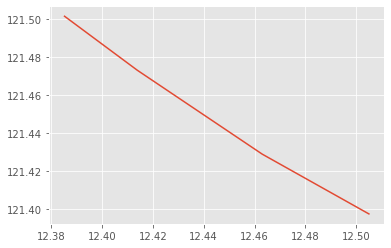

In [9]:
t = [(a[0]-start_time).total_seconds()/60/60 for a in data.Trip[0]]
position = np.array([position_dict[a[1]] for a in data.Trip[0]])

plt.plot(t,position[:,0])

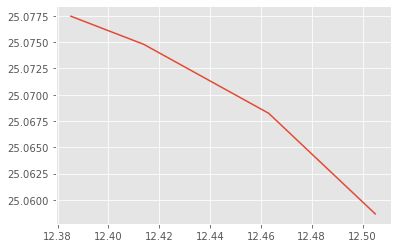

In [10]:
plt.plot(t,position[:,1])

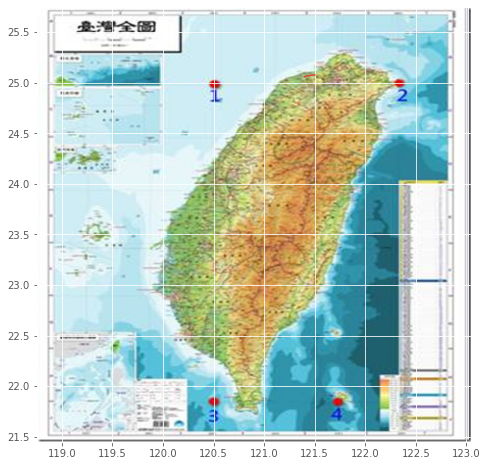

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

taiwan_img_url="https://gis.rchss.sinica.edu.tw/qgis/wp-content/uploads/2009/02/clip-image006-thumb1.jpg"
taiwan_img = Image.open(urlopen(taiwan_img_url))
#taiwan_img = Image.open("taiwan.png")

fig = plt.gcf()
fig.set_size_inches(8,8)
extent=[118.75,123.05,21.45,25.75]
plt.xlim(*extent[:2])
plt.ylim(*extent[2:])
plt.plot(position[:,0], position[:,1])
plt.imshow(np.array(taiwan_img), extent=extent);

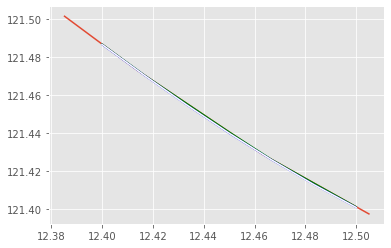

In [12]:
from scipy.interpolate import interp1d

t_space = np.arange(int(min(t)*60+1)/60,max(t),1/60)

f1 = interp1d(t, position, 'linear', axis=0)
f2 = interp1d(t, position, 'quadratic', axis=0)
f3 = interp1d(t, position, 'cubic', axis=0)
plt.plot(t,position[:,0])
plt.plot(t_space, f1(t_space)[:,0],color = 'g')
plt.plot(t_space, f2(t_space)[:,0],color = 'b' )
plt.plot(t_space, f3(t_space)[:,0],color = 'w');

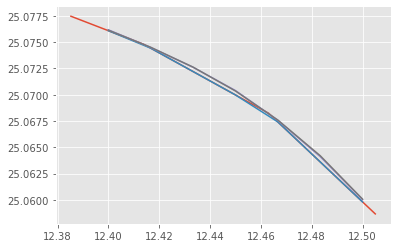

In [13]:
plt.plot(t,position[:,1])
plt.plot(t_space, f1(t_space)[:,1])
plt.plot(t_space, f2(t_space)[:,1])
plt.plot(t_space, f3(t_space)[:,1]);

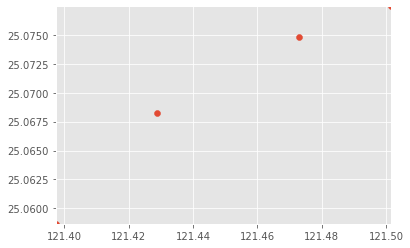

In [18]:
# 打底
scatters = plt.scatter(position[:,0], position[:,1])
plt.margins(0,0)
fig = plt.gcf()

In [19]:
# 動畫
from matplotlib import animation, rc
curv = f1(t_space)
def animate(tick):
    scatters.set_offsets([curv[tick]])
    return [scatters]
anim = animation.FuncAnimation(fig, animate, 
                               frames=len(t_space), interval=100, blit=True)

anim

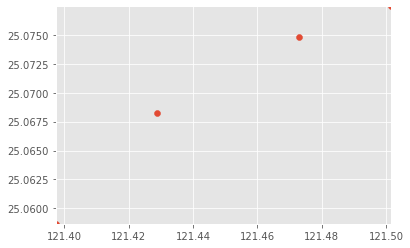

In [16]:
# 開始動畫
from matplotlib import animation, rc
rc('animation', html='html5')
curv = f1(t_space)
def animate(tick):
    scatters.set_offsets([curv[tick]])
    return [scatters]
anim = animation.FuncAnimation(fig, animate, 
                               frames=len(t_space), interval=100, blit=True)

anim

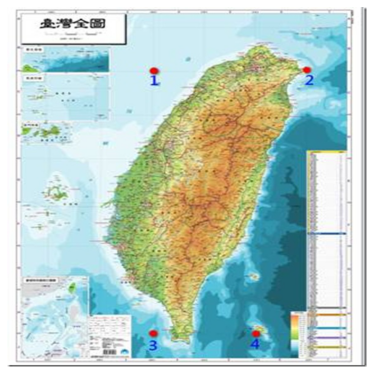

In [20]:
# 打底
fig = plt.gcf()
fig.set_size_inches(5,5)
extent=[118.75,123.05,21.45,25.75]
plt.xlim(*extent[:2])
plt.ylim(*extent[2:])
fig = plt.gcf()
scatters = plt.scatter([],[], alpha=0.5, color='red')
desc_text = plt.text(119,25.3,"",size=25, color="#ff00ff")
plt.axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
bg = plt.imshow(np.array(taiwan_img), extent=extent)

In [21]:
# 開始動畫
from matplotlib import animation, rc
rc('animation', html='html5')
curv = f1(t_space)
def animate(tick):
    scatters.set_offsets([curv[tick]])
    return [scatters]
anim = animation.FuncAnimation(fig, animate, 
                               frames=len(t_space), interval=100, blit=True)

anim